# Download data

In [1]:
%%bash
test -f PAO1_inverted_727667_4788573.fa || gdown 1q0luKgDg_UrMgYTSiy0W3PmZwACEUZTL
test -f HiC_PAO1_R1_001_cutadapt_cut_cor.fastq.gz || gdown 1FGfNFKL0IsGSpE9t7P56n9MqfVTYzyjD
test -f HiC_PAO1_R2_001_cutadapt_cut_cor.fastq.gz || gdown 1h09wxoy3YjsLmQipBcRmpxba92LAHZEc
test -f PAO1_inverted_727667_4788573.chrom.sizes || gdown 1g6p29pzSvk3aPFfpljT4ZC2tIoy-XpyP
test -f HiC_hESC_merged.hg38.mapq_30.10000.mcool || gdown 1qCwVG7H2Yfop2BnDZh5ehDl6yq0KNvzK
test -f Bg3_merged.dm3.mapq_30.1000.mcool || gdown 15-1MxuPNQ8-xjblJS5VIvKFIo3Lr4w9Q
test -f hg38.fa || ( wget -q https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/hg38.fa.gz && gunzip hg38.fa.gz )
test -f dm3.fa || ( wget -q https://hgdownload.cse.ucsc.edu/goldenpath/dm3/bigZips/dm3.fa.gz && gunzip dm3.fa.gz )

# Part 1
## Получение матрицы контактов из ридов (на примере данных для бактерии PAO1). В директории data_for_HiC_HSE лежат fastq-файлы после тримминга с помощью cutadapt, референсный геном (PAO1_inverted_727667_4788573.fa) и файл с размером хромосомы (PAO1_inverted_727667_4788573.chrom.sizes). Цель задания - получить Hi-C карту для PAO1. Включите в отчет картинку получившейся карты (отрисовка полученной матрицы любым удобным способом в питоне) для 2х вариантов: до итеративной коррекции и после. Сравните их. Опишите итеративно-корректированную карту Hi-C, какие характерные для бактерий особенности можно наблюдать на полученной карте ?

# Process data

In [2]:
%%bash
export PATH=${HOME}/.local/bin:${PATH}
test -f PAO1_inverted_727667_4788573.fa.bwt || ( bwa index PAO1_inverted_727667_4788573.fa )

test -f HiC_PAO.bam || ( bwa mem -t 5 -SP PAO1_inverted_727667_4788573.fa \
    HiC_PAO1_R1_001_cutadapt_cut_cor.fastq.gz \
    HiC_PAO1_R2_001_cutadapt_cut_cor.fastq.gz \
    | samtools view -Sb  > HiC_PAO.bam )
test -f PAO.pairs.gz || ( pairtools parse -o PAO.pairs.gz \
    -c ~/HiC/PAO1_inverted_727667_4788573.chrom.sizes \
    --drop-sam --drop-seq --add-columns \
    mapq ~/HiC/HiC_PAO.bam )

test -f PAO.sorted.pairs.gz || ( pairtools sort --nproc 5 -o ~/HiC/PAO.sorted.pairs.gz ~/HiC/PAO.pairs.gz )

In [3]:
%%bash
test -f PAO.nodups.pairs.gz || pairtools dedup \
    --max-mismatch 3 \
    --mark-dups \
    --output \
        >( pairtools split \
            --output-pairs ~/HiC/PAO.nodups.pairs.gz \
            --output-sam ~/HiC/PAO.nodups.bam \
         ) \
    --output-unmapped \
        >( pairtools split \
            --output-pairs ~/HiC/PAO.unmapped.pairs.gz \
            --output-sam ~/HiC/PAO.unmapped.bam \
         ) \
    --output-dups \
        >( pairtools split \
            --output-pairs ~/HiC/PAO.dups.pairs.gz \
            --output-sam ~/HiC/PAO.dups.bam \
         ) \
    --output-stats ~/HiC/PAO.dedup.stats \
      ~/HiC/PAO.sorted.pairs.gz

test -f PAO.1000.cool || cooler cload pairs -c1 2 -p1 3 -c2 4 -p2 5 PAO1_inverted_727667_4788573.chrom.sizes:1000 PAO.nodups.pairs.gz PAO.1000.cool
test -f PAO.1000.mcool || cooler zoomify --balance -r 1000,2000 PAO.1000.cool

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pysam
import bioframe
import cooler

import cooltools
from cooltools import insulation
import cooltools.lib.plotting
from cooltools.lib.numutils import fill_diag

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
import os

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

bp_formatter = EngFormatter('b')

In [6]:
def format_ticks(ax, x=True, y=True, rotate=True, bp_formatter=bp_formatter):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

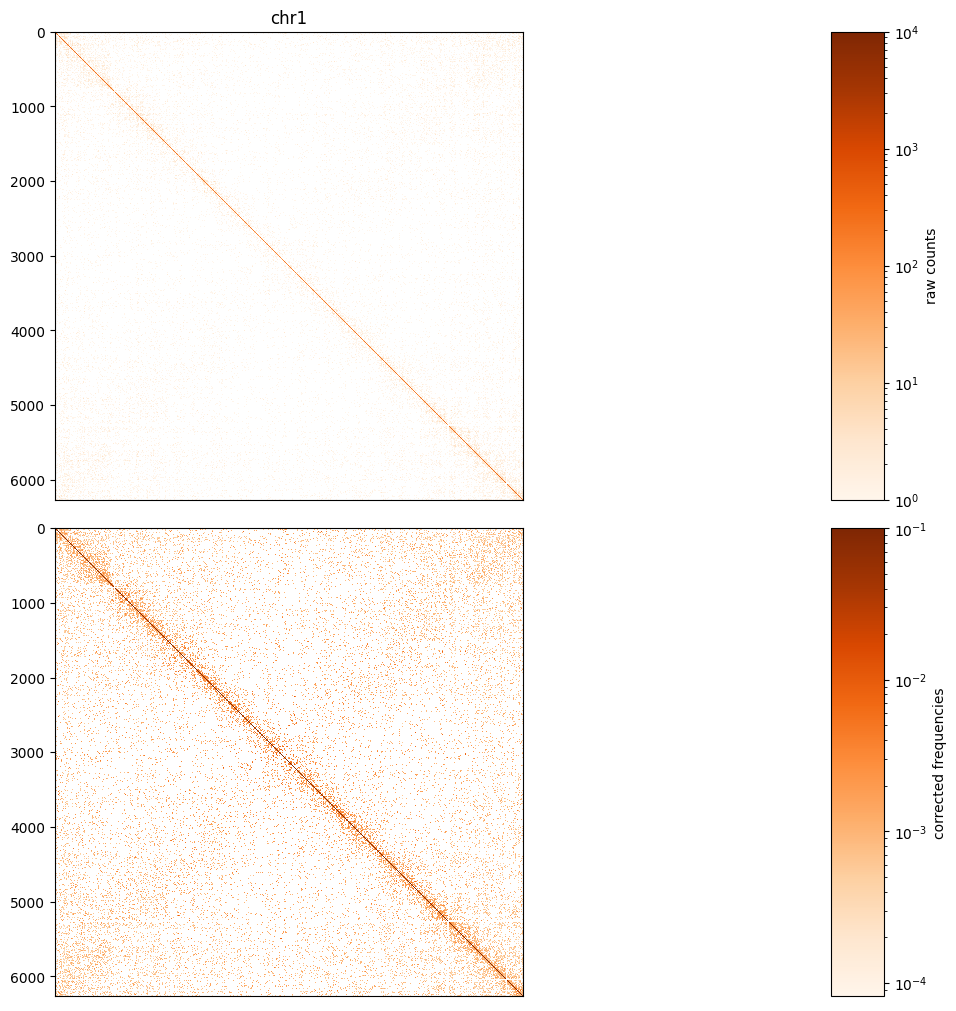

In [7]:
### plot the raw and corrected data in logscale ###
def print_raw_and_balanced(clr: cooler.api.Cooler) -> None:
    plt_width=4
    f, axs = plt.subplots(
        figsize=((plt_width+2)*2, (plt_width+1)*2),
        ncols=2,
        nrows=2,
        gridspec_kw={'height_ratios':[4,4],"wspace":0.01,'width_ratios':[1,.05]},
        constrained_layout=True
    )
    
    region = 'chr1'
    norm = LogNorm(vmax=0.1)
    norm_raw = LogNorm(vmin=1, vmax=10_000)

    ax = axs[0,0]
    im = ax.matshow(
            clr.matrix(balance=False).fetch(region),
        norm=norm_raw,
        cmap='Oranges'
    );
    ax.set_title('chr1')
    ax.xaxis.set_visible(False)

    cax = axs[0,1]
    plt.colorbar(im, cax=cax, label='raw counts');

    ax = axs[1,0]
    im = ax.matshow(
        clr.matrix(balance=True).fetch(region),
        norm=norm,
        cmap='Oranges',
    );
    ax.xaxis.set_visible(False)

    cax = axs[1,1]
    plt.colorbar(im, cax=cax, label='corrected frequencies');
print_raw_and_balanced(cooler.Cooler('PAO.1000.mcool::resolutions/1000'))

### Опишите итеративно-корректированную карту Hi-C, какие характерные для бактерий особенности можно наблюдать на полученной карте ?

На итеративно-корректированной карте можно различить два плеча (в правом нижнем углу) (это характерно для генома бактерии), а также слабую компартментализация (также характерно для генома бактерии), но точно различить вторую диагональ из-за кольцевой структуры генома бактерии не представляется возможным

# Part 2
## Детекция границ с помощью метода insulation из инструмента cooltools. Для готовой Hi-C карты HiC_hESC_merged.hg38.mapq_30.10000.mcool (250kb) определите и визуализируйте границы. Получите таблицу с информацией о значении Insulation score и детектированными границами для трех вариантов окна (см ноутбук) и двух разрешений - 20000 и 40000. Визуализируйте границы вместе с картой предложенными в ноутбуке методами. Оцените разметку для перечисленных вариантов. Какую бы вы выбрали для дальнейшего анализа? Стоит ли, по вашему мнению, включать в финальную разметку слабые границы?

In [8]:
mcool='HiC_hESC_merged.hg38.mapq_30.10000.mcool'

In [9]:
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im


def plot_window(insul_region: pd.DataFrame, ins_ax: plt.Axes, window: int) -> None:
    ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
    ins_ax.plot(
        insul_region[['start', 'end']].mean(axis=1),
        insul_region[f'log2_insulation_score_{window}'],
        label=f'Window {window} bp',
    )

    
def plot_boundaries(insul_region: pd.DataFrame, ins_ax: plt.Axes, window: int) -> None:
    ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
                insul_region[f'log2_insulation_score_{window}'], label=f'Window {window} bp')

    boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{window}'])]
    weak_boundaries = boundaries[~boundaries[f'is_boundary_{window}']]
    strong_boundaries = boundaries[boundaries[f'is_boundary_{window}']]
    ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
                weak_boundaries[f'log2_insulation_score_{window}'], label='Weak boundaries')
    ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
                strong_boundaries[f'log2_insulation_score_{window}'], label='Strong boundaries')


def format_ax(ax: plt.Axes, start: int, stop: int, **kwargs) -> None:
    ax.xaxis.set_visible(False)
    ax.legend(loc="best", ncol=4)
    ax.set_xlim(start, stop)
    format_ticks(ax, **kwargs)


def plot_by_resolution(mcool: str, resolution: int) -> None:
    clr = cooler.Cooler(f'{mcool}::resolutions/{resolution}')
    windows = [3*resolution, 5*resolution, 10*resolution]
    insulation_table = insulation(clr, windows, verbose=True)

    plt.rcParams['font.size'] = 12

    start = 13_500_000
    end = start+ 50*windows[0]
    region = ('chr1', start, end)
    
    fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(18, 6))
    
    im = pcolormesh_45deg(
        axes[0], 
        clr.matrix(balance=True).fetch(region), 
        start=region[1], 
        resolution=resolution, 
        norm=LogNorm(vmax=0.1, vmin=0.001),
        cmap='fall')
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
    plt.colorbar(im, cax=cax)

    
    insul_region = bioframe.select(insulation_table, region)
    for ax, window in zip(axes[1:], windows):
        plot_boundaries(insul_region=insul_region, ins_ax=ax, window=window)
        plot_window(insul_region=insul_region, ins_ax=ax, window=window)
        format_ax(ax, region[1], region[2], y=False, rotate=False)
        
    axes[0].set_ylim(0, 10*windows[0])
    format_ax(axes[0], region[1], region[2], rotate=False)
    

    fig.tight_layout()
    fig.show()

INFO:root:Processing region chr1
INFO:root:Processing region chr2
INFO:root:Processing region chr3
INFO:root:Processing region chr4
INFO:root:Processing region chr5
INFO:root:Processing region chr6
INFO:root:Processing region chr7
INFO:root:Processing region chr8
INFO:root:Processing region chr9
INFO:root:Processing region chr10
INFO:root:Processing region chr11
INFO:root:Processing region chr12
INFO:root:Processing region chr13
INFO:root:Processing region chr14
INFO:root:Processing region chr15
INFO:root:Processing region chr16
INFO:root:Processing region chr17
INFO:root:Processing region chr18
INFO:root:Processing region chr19
INFO:root:Processing region chr20
INFO:root:Processing region chr21
INFO:root:Processing region chr22
INFO:root:Processing region chrX
INFO:root:Processing region chrY
INFO:root:Processing region chrM


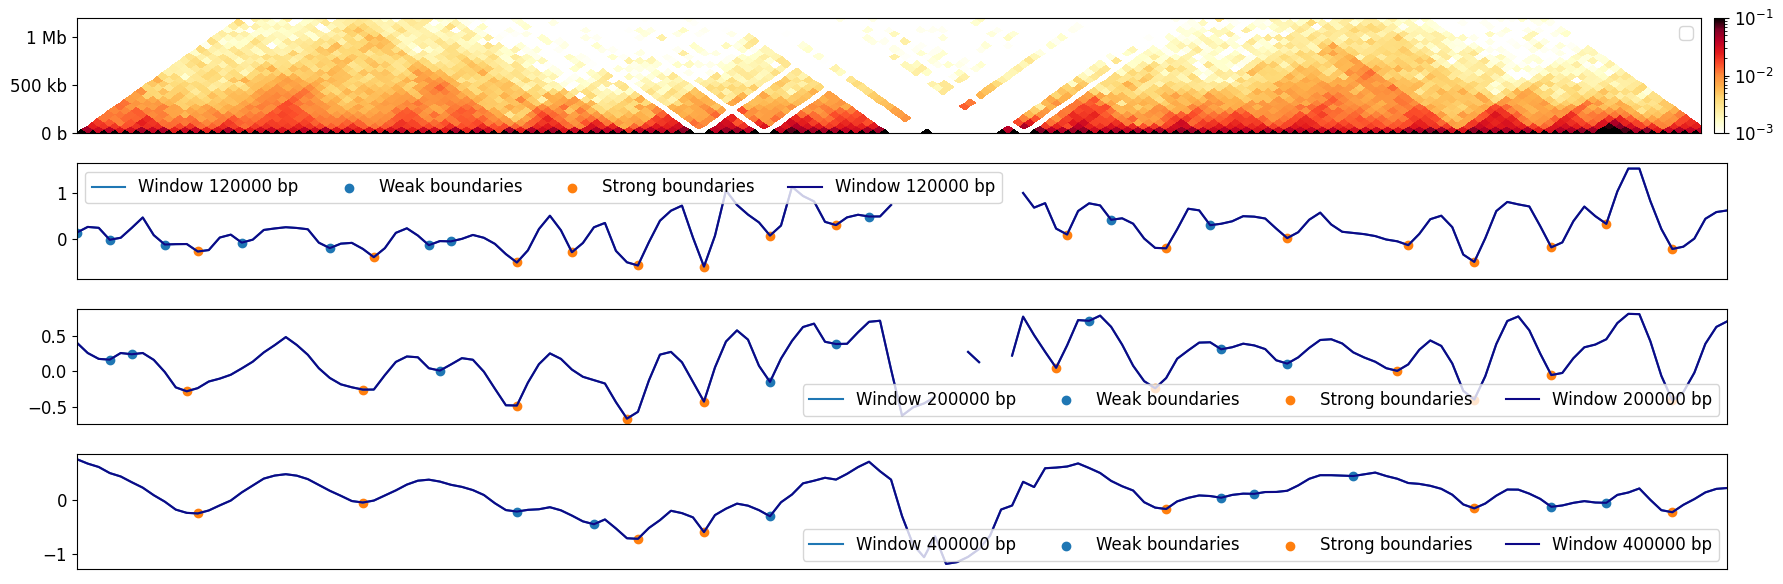

In [10]:
plot_by_resolution(mcool, 40000)

INFO:root:Processing region chr1
INFO:root:Processing region chr2
INFO:root:Processing region chr3
INFO:root:Processing region chr4
INFO:root:Processing region chr5
INFO:root:Processing region chr6
INFO:root:Processing region chr7
INFO:root:Processing region chr8
INFO:root:Processing region chr9
INFO:root:Processing region chr10
INFO:root:Processing region chr11
INFO:root:Processing region chr12
INFO:root:Processing region chr13
INFO:root:Processing region chr14
INFO:root:Processing region chr15
INFO:root:Processing region chr16
INFO:root:Processing region chr17
INFO:root:Processing region chr18
INFO:root:Processing region chr19
INFO:root:Processing region chr20
INFO:root:Processing region chr21
INFO:root:Processing region chr22
INFO:root:Processing region chrX
INFO:root:Processing region chrY
INFO:root:Processing region chrM


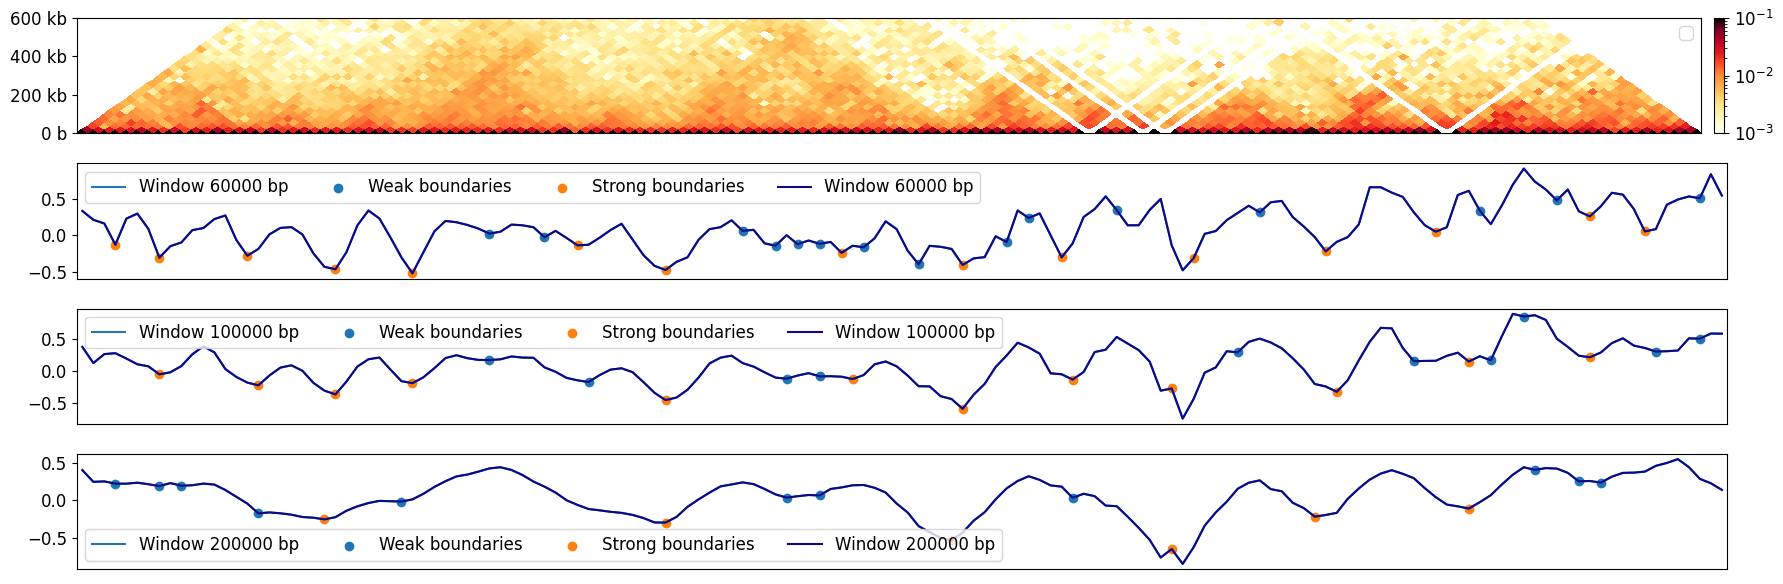

In [11]:
plot_by_resolution(mcool, 20000)

## Оцените разметку для перечисленных вариантов. Какую бы вы выбрали для дальнейшего анализа? Стоит ли, по вашему мнению, включать в финальную разметку слабые границы?

Resolution 40000: стоит использовать меньший размер окна, так как иначе мы можем терять грацниы. Стоит использовать и слабые и сильные границы

Resolution 20000: стоит использовать средний размер окна, так как для большого окна график слишком сглаженный, а для более маленького размера окна слишком "резкий". Слабые границы, скорее всего, не подойдут для анализа, так как компартменты, которые они показывают, не определяются визуально по карте

# Part 3 
## Детекция петель. Получите разметку петель 2 инструментами (cooltools и mustache) для хромосомы 1 и разрешения 20kb. Сравните кол-во петель, полученное двумя способами. Отрисуйте средние хитмэпы вокруг полученных петель и определите, какой инструмент дает более яркий паттерн для "средней петли". Какой инструмент вы бы предпочли для дальнейшей работы? Отрисованные средние хитмэпы и комментарии включите в отчет. Средние хитмэпы получают следующим образом: для каждой петли "вырезаем" из карты контактов квадратный участок размера 21 на 21 (естественно, можно и 10 на 10, и 100 на 100 - на ваше усмотрение), в центре которого располагается петля (яркая точка на карте контактов).

## cooler

In [12]:
def cooltools_loops(clr: cooler.api.Cooler) -> pd.DataFrame:
    # define genomic view that will be used to call dots and pre-compute expected

    # Use bioframe to fetch the genomic features from the UCSC.
    hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
    hg38_cens = bioframe.fetch_centromeres('hg38')
    hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)

    # Select only chromosomes that are present in the cooler.
    hg38_arms = hg38_arms.set_index("chrom").loc[['chr1']].reset_index()

    # intra-arm expected
    expected = cooltools.expected_cis(
        clr,
        view_df=hg38_arms,
        nproc=4,
    )

    return cooltools.dots(
        clr,
        expected=expected,
        view_df=hg38_arms,
        # how far from the main diagonal to call dots:
        max_loci_separation=10_000_000,
        nproc=4,
    )

In [13]:
if not os.path.exists("cooler_cooltools_dots.tsv"):
    cooltools_loops(cooler.Cooler(f'{mcool}::resolutions/20000')).to_csv("cooler_cooltools_dots.tsv", sep="\t", index=False)

## mustache

In [14]:
! test -f cooler_mustache_dots.tsv || ~/.local/bin/mustache -f 'HiC_hESC_merged.hg38.mapq_30.10000.mcool' -ch chr1 -r 20kb -pt 0.05 -o cooler_mustache_dots.tsv

## process

In [15]:
cloops = pd.read_csv("cooler_cooltools_dots.tsv", sep="\t")
cloops.head()

,chrom1,start1,end1,chrom2,start2,end2,count,la_exp.donut.value,la_exp.vertical.value,la_exp.horizontal.value,...,la_exp.vertical.qval,la_exp.horizontal.qval,la_exp.lowleft.qval,region,cstart1,cstart2,c_label,c_size,region1,region2
0,chr1,10260000,10280000,chr1,13660000,13680000,9,1.809567,1.962706,1.338110,...,0.024629,0.008869,0.052058,chr1_p,10250000.0,13650000.0,9,2,chr1_p,chr1_p
1,chr1,12620000,12640000,chr1,15600000,15620000,6,1.168538,0.790576,0.952422,...,0.042308,0.042588,0.033917,chr1_p,12630000.0,15590000.0,59,2,chr1_p,chr1_p
2,chr1,13700000,13720000,chr1,15620000,15640000,14,3.726887,3.946956,5.022985,...,0.021655,0.071245,0.017692,chr1_p,13690000.0,15610000.0,66,2,chr1_p,chr1_p
3,chr1,15120000,15140000,chr1,16120000,16140000,11,1.519223,1.950670,1.665969,...,0.004309,0.004094,0.000059,chr1_p,15120000.0,16120000.0,72,1,chr1_p,chr1_p
4,chr1,11080000,11100000,chr1,11240000,11260000,131,56.711439,69.799010,64.963677,...,0.000018,0.000016,0.000009,chr1_p,11080000.0,11240000.0,120,1,chr1_p,chr1_p


In [16]:
mloops = pd.read_csv("cooler_mustache_dots.tsv", sep="\t")
mloops.head()

,BIN1_CHR,BIN1_START,BIN1_END,BIN2_CHROMOSOME,BIN2_START,BIN2_END,FDR,DETECTION_SCALE
0,chr1,111480000,111500000,chr1,112300000,112320000,0.039495,2.111213
1,chr1,111780000,111800000,chr1,112320000,112340000,0.011383,2.111213
2,chr1,113140000,113160000,chr1,113680000,113700000,0.002606,2.111213
3,chr1,113960000,113980000,chr1,114280000,114300000,0.020049,2.111213
4,chr1,115140000,115160000,chr1,115580000,115600000,0.042391,2.111213


In [17]:
for t, d in zip(["cooltools", "mustache"], [cloops, mloops]):
    print(f"loops with {t} found: {d.shape[0]}")

loops with cooltools found: 620
loops with mustache found: 77


In [18]:
def count_matrix(region_matrix: np.ndarray, dots_df: pd.DataFrame, binsize: int, n: int = 50) -> np.ndarray:
    n_s = n // 2
    n_e = n // 2
    if n % 2 != 0:
        n_e += 1

    ls = np.zeros((dots_df.shape[0], n, n))
    count_coord = lambda start,end: int((start + end) / (2 * binsize))
    for x in dots_df.itertuples():
        start1, start2 = count_coord(x.start1, x.end1), count_coord(x.start2, x.end2)
        ls[x.Index] = region_matrix[start1-n_s:start1+n_e,start2-n_s:start2+n_e]
    return np.nanmean(ls, axis=0)

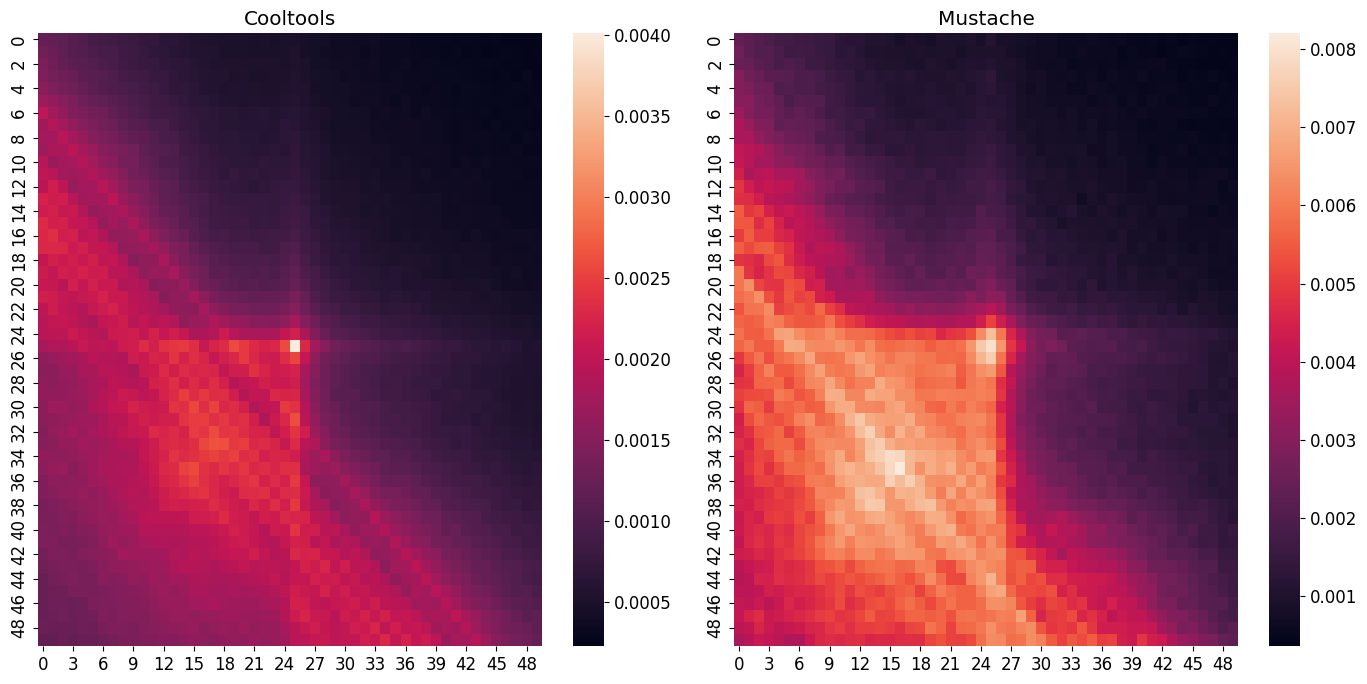

In [19]:
clr = cooler.Cooler(f'{mcool}::resolutions/20000')
region_matrix = clr.matrix(balance=True).fetch("chr1")
for diag in [-1,0,1]:
    region_matrix = fill_diag(region_matrix, np.nan, i=diag)

f, ax = plt.subplots(1, 2, figsize=(14, 7))

sns.heatmap(
    data=count_matrix(
        region_matrix=region_matrix,
        dots_df=cloops,
        binsize=clr.binsize,
    ),
    ax=ax[0],
)

sns.heatmap(
    data=count_matrix(region_matrix=region_matrix, dots_df=mloops.rename(
        columns={
            "BIN1_START": "start1",
            "BIN1_END": "end1",
            "BIN2_START": "start2",
            "BIN2_END": "end2",
        },
    ),
    binsize=clr.binsize),
    ax=ax[1],
)

ax[0].set_title("Cooltools")
ax[1].set_title("Mustache")

plt.tight_layout()
plt.show()

### Отрисуйте средние хитмэпы вокруг полученных петель и определите, какой инструмент дает более яркий паттерн для "средней петли". Какой инструмент вы бы предпочли для дальнейшей работы?

У Mustache петли больше и с очень размытыми границами (возможно, связано с чувствительностью, из-за этого и количество петель меньше). Для анализа взял бы cooltools, так как у петель более четкие границы и они меньше "фонят".

# Part 4
## Получение разметки компартментов и построение saddle plot. Для двух организмов (мушка и человек) выберете какую-нибудь хромосому*, получите первый собственный вектор, характеризующий принадлежность к компартментам, и постройте saddle plot (просто отрисуйте полученную матрицу любым способом в питоне). Опишите, что отображено на saddle plot и какие различия в структуре компартментов наблюдаются у мушки и человека. Данные: Bg3_merged.dm3.mapq_30.1000.mcool (разрешение 20kb) - нервная ткань (Drosophila) HiC_hESC_merged.hg38.mapq_30.10000.mcool (разрешение 250kb) - hESC (человек) Для определения первого собственного вектора вам понадобится геном человека и плодовой мушки (hg38.fa и dm3.fa). Загрузите его самостоятельно на свой гугл-диск.

In [20]:
import warnings
from cytoolz import merge

def saddleplot(
    track,
    saddledata,
    n_bins,
    vrange=None,
    qrange=(0.0, 1.0),
    cmap="coolwarm",
    scale="log",
    vmin=0.5,
    vmax=2,
    color=None,
    title=None,
    xlabel=None,
    ylabel=None,
    clabel=None,
    fig=None,
    fig_kws=None,
    heatmap_kws=None,
    margin_kws=None,
    cbar_kws=None,
    subplot_spec=None,
):
    """
    Generate a saddle plot.
    Parameters
    ----------
    track : pd.DataFrame
        See cooltools.digitize() for details.
    saddledata : 2D array-like
        Saddle matrix produced by `make_saddle`. It will include 2 flanking
        rows/columns for outlier signal values, thus the shape should be
        `(n+2, n+2)`.
    cmap : str or matplotlib colormap
        Colormap to use for plotting the saddle heatmap
    scale : str
        Color scaling to use for plotting the saddle heatmap: log or linear
    vmin, vmax : float
        Value limits for coloring the saddle heatmap
    color : matplotlib color value
        Face color for margin bar plots
    fig : matplotlib Figure, optional
        Specified figure to plot on. A new figure is created if none is
        provided.
    fig_kws : dict, optional
        Passed on to `plt.Figure()`
    heatmap_kws : dict, optional
        Passed on to `ax.imshow()`
    margin_kws : dict, optional
        Passed on to `ax.bar()` and `ax.barh()`
    cbar_kws : dict, optional
        Passed on to `plt.colorbar()`
    subplot_spec : GridSpec object
        Specify a subregion of a figure to using a GridSpec.
    Returns
    -------
    Dictionary of axes objects.
    """

#     warnings.warn(
#         "Generating a saddleplot will be deprecated in future versions, "
#         + "please see https://github.com/open2c_examples for examples on how to plot saddles.",
#         DeprecationWarning,
#     )

    from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
    from matplotlib.colors import Normalize, LogNorm
    from matplotlib import ticker
    import matplotlib.pyplot as plt

    class MinOneMaxFormatter(ticker.LogFormatter):
        def set_locs(self, locs=None):
            self._sublabels = set([vmin % 10 * 10, vmax % 10, 1])

        def __call__(self, x, pos=None):
            if x not in [vmin, 1, vmax]:
                return ""
            else:
                return "{x:g}".format(x=x)

    track_value_col = track.columns[3]
    track_values = track[track_value_col].values

    digitized_track, binedges = cooltools.digitize(
        track, n_bins, vrange=vrange, qrange=qrange
    )
    x = digitized_track[digitized_track.columns[3]].values.astype(int).copy()
    x = x[(x > -1) & (x < len(binedges) + 1)]

    # Old version
    # hist = np.bincount(x, minlength=len(binedges) + 1)

    groupmean = track[track.columns[3]].groupby(digitized_track[digitized_track.columns[3]]).mean()

    if qrange is not None:
        lo, hi = qrange
        binedges = np.linspace(lo, hi, n_bins + 1)

    # Barplot of mean values and saddledata are flanked by outlier bins
    n = saddledata.shape[0]
    X, Y = np.meshgrid(binedges, binedges)
    C = saddledata
    if (n - n_bins) == 2:
        C = C[1:-1, 1:-1]
        groupmean = groupmean[1:-1]

    # Layout
    if subplot_spec is not None:
        GridSpec = partial(GridSpecFromSubplotSpec, subplot_spec=subplot_spec)
    grid = {}
    gs = GridSpec(
        nrows=3,
        ncols=3,
        width_ratios=[0.2, 1, 0.1],
        height_ratios=[0.2, 1, 0.1],
        wspace=0.05,
        hspace=0.05,
    )

    # Figure
    if fig is None:
        fig_kws_default = dict(figsize=(5, 5))
        fig_kws = merge(fig_kws_default, fig_kws if fig_kws is not None else {})
        fig = plt.figure(**fig_kws)

    # Heatmap
    if scale == "log":
        norm = LogNorm(vmin=vmin, vmax=vmax)
    elif scale == "linear":
        norm = Normalize(vmin=vmin, vmax=vmax)
    else:
        raise ValueError("Only linear and log color scaling is supported")

    grid["ax_heatmap"] = ax = plt.subplot(gs[4])
    heatmap_kws_default = dict(cmap="coolwarm", rasterized=True)
    heatmap_kws = merge(
        heatmap_kws_default, heatmap_kws if heatmap_kws is not None else {}
    )
    img = ax.pcolormesh(X, Y, C, norm=norm, **heatmap_kws)
    plt.gca().yaxis.set_visible(False)

    # Margins
    margin_kws_default = dict(edgecolor="k", facecolor=color, linewidth=1)
    margin_kws = merge(margin_kws_default, margin_kws if margin_kws is not None else {})
    # left margin hist
    grid["ax_margin_y"] = plt.subplot(gs[3], sharey=grid["ax_heatmap"])

    plt.barh(
        binedges, height=1/len(binedges), width=groupmean, align="edge", **margin_kws
    )

    plt.xlim(plt.xlim()[1], plt.xlim()[0])  # fliplr
    plt.ylim(hi, lo)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    # top margin hist
    grid["ax_margin_x"] = plt.subplot(gs[1], sharex=grid["ax_heatmap"])

    plt.bar(
        binedges, width=1/len(binedges), height=groupmean, align="edge", **margin_kws
    )

    plt.xlim(lo, hi)
    # plt.ylim(plt.ylim())  # correct
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    plt.gca().yaxis.set_visible(False)

#     # Colorbar
    grid["ax_cbar"] = plt.subplot(gs[5])
    cbar_kws_default = dict(fraction=0.8, label=clabel or "")
    cbar_kws = merge(cbar_kws_default, cbar_kws if cbar_kws is not None else {})
    if scale == "linear" and vmin is not None and vmax is not None:
        grid["ax_cbar"] = cb = plt.colorbar(img, **cbar_kws)
        # cb.set_ticks(np.arange(vmin, vmax + 0.001, 0.5))
        # # do linspace between vmin and vmax of 5 segments and trunc to 1 decimal:
        decimal = 10
        nsegments = 5
        cd_ticks = np.trunc(np.linspace(vmin, vmax, nsegments) * decimal) / decimal
        cb.set_ticks(cd_ticks)
    else:
        # print('cbar')

        cb = plt.colorbar(img, format=MinOneMaxFormatter(), cax=grid["ax_cbar"], **cbar_kws)
        cb.ax.yaxis.set_minor_formatter(MinOneMaxFormatter())

    # extra settings
    grid["ax_heatmap"].set_xlim(lo, hi)
    grid["ax_heatmap"].set_ylim(hi, lo)
    grid['ax_heatmap'].grid(False)
    if title is not None:
        grid["ax_margin_x"].set_title(title)
    if xlabel is not None:
        grid["ax_heatmap"].set_xlabel(xlabel)
    if ylabel is not None:
        grid["ax_margin_y"].set_ylabel(ylabel)

    return grid

In [21]:
def make_saddleplot(genome: OrderedDict, clr: cooler.api.Cooler, chromosome: str,
                    n_groups: int = 30, q_lo: float = 0.01, q_hi: float = 0.99) -> None:
    print(chromosome)
    bins = clr.bins()[:]
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], genome)

    view_df = pd.DataFrame(
        {
            'chrom': [chromosome],
            'start': 0,
            'end': [clr.chromsizes.values[clr.chromnames.index(chromosome)]],
            'name': [chromosome]
        }
    )
    
    cis_eigs = cooltools.eigs_cis(
        clr,
        gc_cov,
        view_df=view_df,
        n_eigs=3,
    )
    eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]


    cvd = cooltools.expected_cis(
            clr=clr,view_df=view_df
    )

    interaction_sum, interaction_count =  cooltools.saddle(
            clr,
            cvd,
            eigenvector_track,
            'cis',
            n_bins=n_groups,
            qrange=(q_lo,q_hi),
            view_df=view_df
    )
    
    saddleplot(
        track=eigenvector_track,
        saddledata=interaction_sum/interaction_count,
        n_bins=n_groups,
        qrange=(q_lo,q_hi),
        cbar_kws=dict(label='average observed/expected contact frequency'),
        fig_kws=dict(figsize=(10, 10))
    )
    plt.show()

chr15


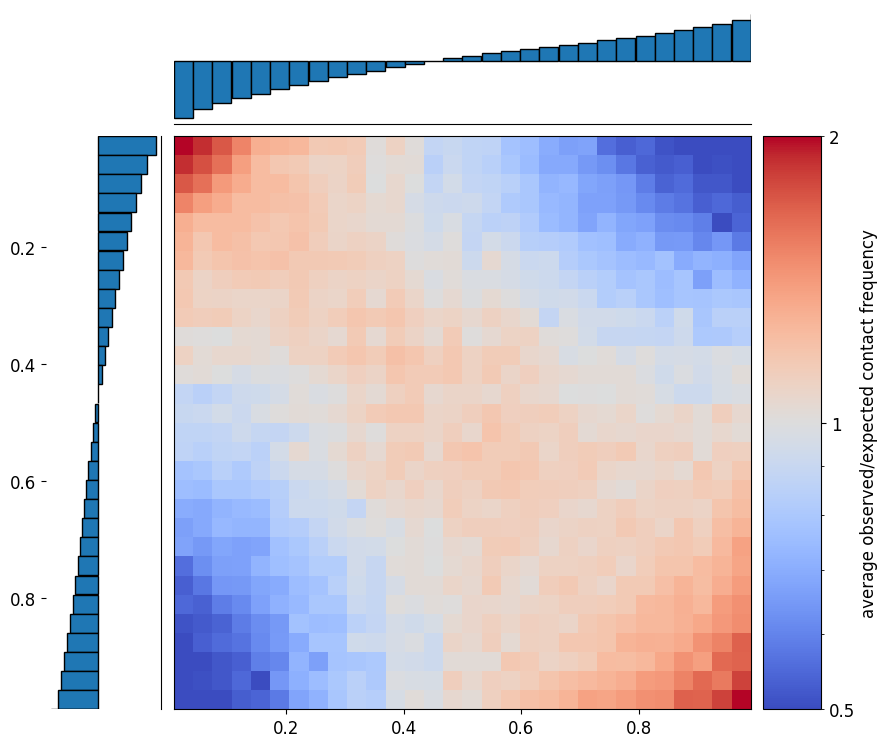

In [22]:
genome = bioframe.load_fasta("./hg38.fa")
clr = cooler.Cooler('HiC_hESC_merged.hg38.mapq_30.10000.mcool::resolutions/20000')
_ = make_saddleplot(clr=clr, genome=genome, chromosome="chr15")

chr2L


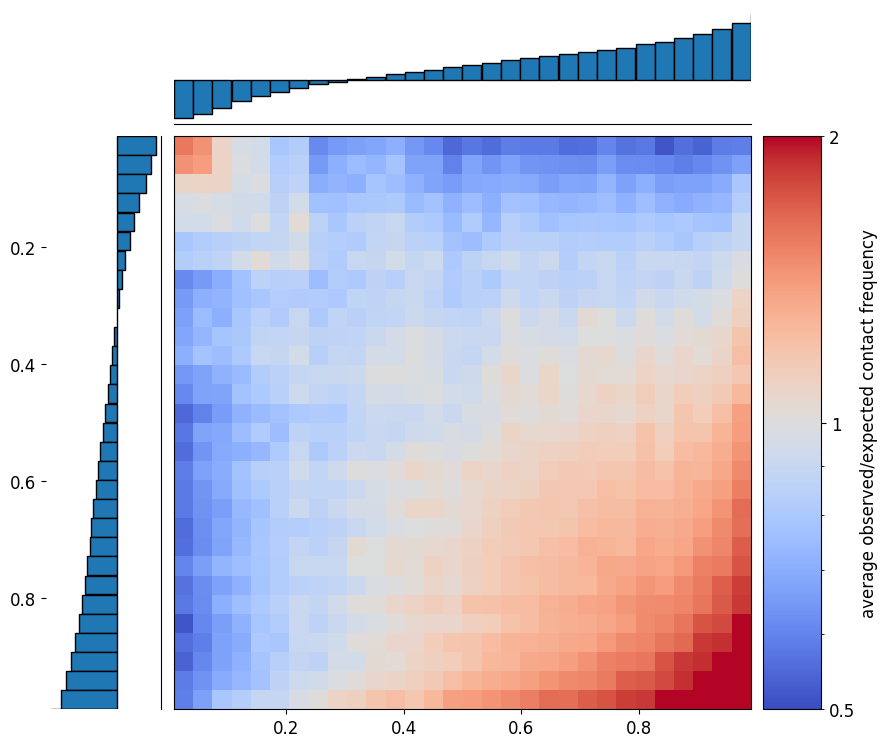

In [23]:
genome = bioframe.load_fasta("./dm3.fa")
clr = cooler.Cooler('Bg3_merged.dm3.mapq_30.1000.mcool::resolutions/25000')
_ = make_saddleplot(clr=clr, genome=genome, chromosome="chr2L")

## Опишите, что отображено на saddle plot и какие различия в структуре компартментов наблюдаются у мушки и человека

Для анализа я взял 2ую хромосому человека и хромосому 2L мушки.
По графикам видно, что у мухи неактивный хроматин менее компактизован и находится в более релаксированном состоянии, чем неактивный хроматин у человека. Также на хромосоме человека видно большее количество взаимодействий между компартментами активного хроматина.